## Import Libraries, Load Data, and Train-Test-Split

In [1]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from modules.preprocessing import encode_data, feature_select, pca_select
from modules.training import fit_all_models
from modules.utils import load_models_of_type
from modules.model_evaluation import metrics_across_models, plot_roc_curves
from modules.model_evaluation import plot_prc, train_test_performance

In [2]:
df = pd.read_csv('../data/cleaned/telco-churn-data-cleaned-not-encoded.csv')
df

gender  senior_citizen partner dependents  tenure phone_service  \
0     Female               0     Yes         No       1            No   
1       Male               0      No         No      34           Yes   
2       Male               0      No         No       2           Yes   
3       Male               0      No         No      45            No   
4     Female               0      No         No       2           Yes   
...      ...             ...     ...        ...     ...           ...   
7038    Male               0     Yes        Yes      24           Yes   
7039  Female               0     Yes        Yes      72           Yes   
7040  Female               0     Yes        Yes      11            No   
7041    Male               1     Yes         No       4           Yes   
7042    Male               0      No         No      66           Yes   

        multiple_lines internet_service online_security online_backup  \
0     No phone service              DSL              No           Yes   
1                   No              DSL             Yes            No   
2                   No              DSL             Yes           Yes   
3     No phone service              DSL             Yes            No   
4                   No      Fiber optic              No            No   
...                ...              ...             ...           ...   
7038               Yes              DSL             Yes            No   
7039               Yes      Fiber optic              No           Yes   
7040  No phone service              DSL             Yes            No   
7041               Yes      Fiber optic              No            No   
7042                No      Fiber optic             Yes            No   

     device_protection tech_support streaming_tv streaming_movies  \
0                   No           No           No               No   
1                  Yes           No           No               No   
2                   No           No           No               No   
3                  Yes          Yes           No               No   
4                   No           No           No               No   
...                ...          ...          ...              ...   
7038               Yes          Yes          Yes              Yes   
7039               Yes           No          Yes              Yes   
7040                No           No           No               No   
7041                No           No           No               No   
7042               Yes          Yes          Yes              Yes   

            contract paperless_billing             payment_method  \
0     Month-to-month               Yes           Electronic check   
1           One year                No               Mailed check   
2     Month-to-month               Yes               Mailed check   
3           One year                No  Bank transfer (automatic)   
4     Month-to-month               Yes           Electronic check   
...              ...               ...                        ...   
7038        One year               Yes               Mailed check   
7039        One year               Yes    Credit card (automatic)   
7040  Month-to-month               Yes           Electronic check   
7041  Month-to-month               Yes               Mailed check   
7042        Two year               Yes  Bank transfer (automatic)   

      monthly_charges  total_charges churn  
0               29.85          29.85    No  
1               56.95        1889.50    No  
2               53.85         108.15   Yes  
3               42.30        1840.75    No  
4               70.70         151.65   Yes  
...               ...            ...   ...  
7038            84.80        1990.50    No  
7039           103.20        7362.90    No  
7040            29.60         346.45    No  
7041            74.40         306.60   Yes  
7042           105.65        6844.50    No  

[7043 rows x 20 columns]

In [3]:
# Split the data into independent and dependent variables
X = df.drop(['churn'], axis = 1)
y = df['churn']

# Create a split using sklearn's train test split, using a random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Encoding and Feature Selection

In [4]:
X_train_encoded, X_test_encoded = encode_data(X_train, X_test)

In [5]:
# Label encoding of target variable: Not Churn = 0, Churn = 1
le = LabelEncoder()
y_train_encoded = pd.Series(le.fit_transform(y_train), index = y_train.index, name = 'churn')
y_test_encoded = pd.Series(le.transform(y_test), index = y_test.index, name = 'churn')

In [6]:
# Top K full features
X_sets = {k: feature_select(X_train_encoded, y_train, X_test_encoded, N = k) for k in [5, 7, 9, 11]}
X_train_features = {k: v[0] for k, v in X_sets.items()}
X_test_features = {k: v[1] for k, v in X_sets.items()}

In [7]:
# Displaying Top K full features
selected_features = {k:(set([re.search('([a-z]+_?[a-z]*)_?[A-Z]?', i)[1] for i in X_sets[k][0].columns]))
                     for k in X_sets.keys()}
print(*[f'Top {k} Features: {selected_features[k]}' for k in [5, 7, 9, 11]], sep = '\n')

Top 5 Features: {'payment_method', 'online_security', 'contract_', 'tenure', 'paperless_billing'}
Top 7 Features: {'payment_method', 'online_security', 'tech_support', 'contract_', 'dependents_', 'tenure', 'paperless_billing'}
Top 9 Features: {'payment_method', 'online_security', 'tech_support', 'partner_', 'contract_', 'dependents_', 'tenure', 'senior_citizen', 'paperless_billing'}
Top 11 Features: {'payment_method', 'online_security', 'tech_support', 'streaming_movies', 'partner_', 'contract_', 'dependents_', 'online_backup', 'tenure', 'senior_citizen', 'paperless_billing'}


In [8]:
# Tested using 4 components, but the variance explained ended up only being ~67.5%
X_train_pca, X_test_pca, variances = pca_select(X_train_encoded, X_test_encoded, n_components = 4)
print(f'Number of features: {len(variances)}', f'Explained Variance: {variances.sum()}', sep = '\n')

Number of features: 4
Explained Variance: 0.6745719238982121


In [9]:
# Using explained variance ratio with a minimum delta of 0.025, ended up with 9 components at ~81.8% explained variance
X_train_pca, X_test_pca, variances = pca_select(X_train_encoded, X_test_encoded,
                                                explained_ratio = 0.8, component_delta = 0.025)
print(f'Number of features: {len(variances)}', f'Explained Variance: {variances.sum()}', sep = '\n')

Number of features: 9
Explained Variance: 0.8181911453461347


In [10]:
# Group training and testing feature sets for further use
X_trains = [X_train_encoded, X_train_features, X_train_pca]
X_tests = [X_test_encoded, X_test_features, X_test_pca]

## Training / Modeling

### Logistic Regression

In [11]:
logreg = ('logreg', LogisticRegression(solver = 'liblinear', random_state = 42))

In [12]:
# Test different regularization types and strengths, as well as max iterations
params = {
    'logreg__penalty': ['l2', 'l1'],
    'logreg__C': [0.1, 0.5, 1, 10, 50, 100],
    'logreg__max_iter': [100, 500, 1000]
}

In [13]:
# fit_all_models(X_trains, y_train_encoded, logreg[0], logreg[1], params = params, compression = 'lzma')

### Naive Bayes

In [14]:
nb = ('bayes', BernoulliNB())

In [15]:
# Naive Bayes has very few hyperparameters to tune
params = {
    'bayes__alpha': [10**(i) for i in range(-4, 4)]
}

In [16]:
# fit_all_models(X_trains, y_train_encoded, nb[0], nb[1], params = params, compression = 'lzma')

### Random Forest

In [17]:
rf = ('forest', RandomForestClassifier(n_estimators = 800, n_jobs = -1, random_state = 42))

In [18]:
# Random Forests take a while to train compared to many other models
# Limited hyperparameter tuning using 800 trees for the sake of time
# Note, we do not need to change the number of trees as a hyperparameter for a bagged classifier
# Hyperparameter tuning limits the ability of the forest to learn, preventing overfitting
params = {
    'forest__max_features': [1, 'sqrt'],
    'forest__min_samples_leaf': [1, 0.1],
    'forest__max_depth': [None, 3, 7]
}

In [19]:
# fit_all_models(X_trains, y_train_encoded, rf[0], rf[1], params = params, compression = 'lzma')

### XGBoost

In [20]:
boost = ('xgboost', XGBClassifier(n_jobs = -1, random_state = 42))

In [21]:
# XGBoost has many hyperparameters to tune and for best results, successive grid searches would be best
# For the sake of time, only the following hyperparameters were tuned (each grid search still evaluates 144 models)
# Number of trees does need to be tuned, as a boosted classifier learns from prior iterations
# Like with Random Forest, the following hyperparameters are designed to help prevent overfitting
params = {
    'xgboost__n_estimators': [100, 200, 400],
    'xgboost__max_depth': [3, 5, 7],
    'xgboost__learning_rate': [0.01, 0.1],
    'xgboost__min_child_weight': [1, 0.1],
    'xgboost__subsample': [0.5, 1],
    'xgboost__colsample_bytree': [0.5, 1],
}

In [22]:
# fit_all_models(X_trains, y_train_encoded, boost[0], boost[1], params = params, compression = 'lzma')

## Evaluation

### Loading Models

In [23]:
logistic_models = load_models_of_type('logreg', ext = '.pickle.xz')
forest_models = load_models_of_type('forest', ext = '.pickle.xz')
bayes_models = load_models_of_type('bayes', ext = '.pickle.xz')
xgb_models = load_models_of_type('xgboost', ext = '.pickle.xz')

Successfully loaded model from ../models/logreg/logreg_base.pickle.xz
Successfully loaded model from ../models/logreg/logreg_grid.pickle.xz
Successfully loaded model from ../models/logreg/logreg_pca.pickle.xz
Successfully loaded model from ../models/logreg/logreg_top05.pickle.xz
Successfully loaded model from ../models/logreg/logreg_top07.pickle.xz
Successfully loaded model from ../models/logreg/logreg_top09.pickle.xz
Successfully loaded model from ../models/logreg/logreg_top11.pickle.xz
Successfully loaded model from ../models/logreg/logreg_base_SMOTE.pickle.xz
Successfully loaded model from ../models/logreg/logreg_grid_SMOTE.pickle.xz
Successfully loaded model from ../models/logreg/logreg_pca_SMOTE.pickle.xz
Successfully loaded model from ../models/logreg/logreg_top05_SMOTE.pickle.xz
Successfully loaded model from ../models/logreg/logreg_top07_SMOTE.pickle.xz
Successfully loaded model from ../models/logreg/logreg_top09_SMOTE.pickle.xz
Successfully loaded model from ../models/logreg/l

### Classification Metrics

#### Explanation

- Accuracy measures the ability for a model to correctly predict positive and negative labels (0 and 1, or No Churn and Churn in this dataset); however, accuracy is infamously deceptive on classification tasks with large class imbalances, as always predicting the majority class can lead to a highly accurate but useless classifier.
- Precision measures how effective the model's positive predictions are. A highly precise model's positive predictions are more likely to be true, while an imprecise model's positive predictions are not very trustworthy.
- Recall measures how effective the model is at capturing the positive class. A model with a high recall is effective at classifying actual positive class members at belonging to the positive class, while a model with low recall struggles to properly predict the underlying positive class.
- F1-Score is defined as the harmonic mean of precision and recall. This means it is a type of average, and it highly penalizes when either precision or recall is substantially higher than the other. F1-Score is useful for selecting a classifier that balances recall and precision.

All of the models except for Naive Bayes struggle to capture the (undersampled) positive class without SMOTE resampling to adjust for class imbalances, as denoted by low recall scores. Naive Bayes has a tendency to overpredict the positive class, leading to poor precision but high recall due to the simplistic and highly biased nature of the model.

Logistic Regression, Random Forest, and XGBoost all appear to perform similarly, with Logistic Regression showing a tendency towards higher recall and lower precision, Random Forest trading some recall for more precision, and XGBoost trading even more recall for precision. This is to be expected, as Logistic Regression is a low-complexity linear model, while Random Forest and XGBoost are designed to model more complex class separations, allowing them to fit more closely to the data.

In [24]:
metrics_across_models('Logistic Regression', logistic_models, X_tests, y_test_encoded)

In [25]:
metrics_across_models('Random Forest', forest_models, X_tests, y_test_encoded)

In [26]:
metrics_across_models('Naive Bayes', bayes_models, X_tests, y_test_encoded)

In [27]:
metrics_across_models('XGBoost', xgb_models, X_tests, y_test_encoded)

### Receiver Operator Characteristic (ROC) Curves

#### Explanation
Receiver Operator Characteristic (ROC) Curves are used to visualize the trade-off between recall and false positive rate for a model at different decision thresholds for classification. 

A higher area under the curve (ROC AUC) indicates a stronger classifier, as the classifier is able to obtain higher levels of recall with lower false positive rate. The optimal ROC AUC is 1, and a strong classifier pull to the top left of the graph. A baseline unskilled classifier predicts the classes according to their proportion in the data set, thus always having an equal chance of predicting the positive class correctly, resulting in an ROC AUC of 0.5.

The ROC Curve allows us to visualize how we can use the predicted probabilities of models to increase the recall of a model without changing its parameters and how much false positive rate we introduce by doing so.

Logistic Regression appears to perform the best out of all of the models by ROC AUC although all models show fairly similar performance.

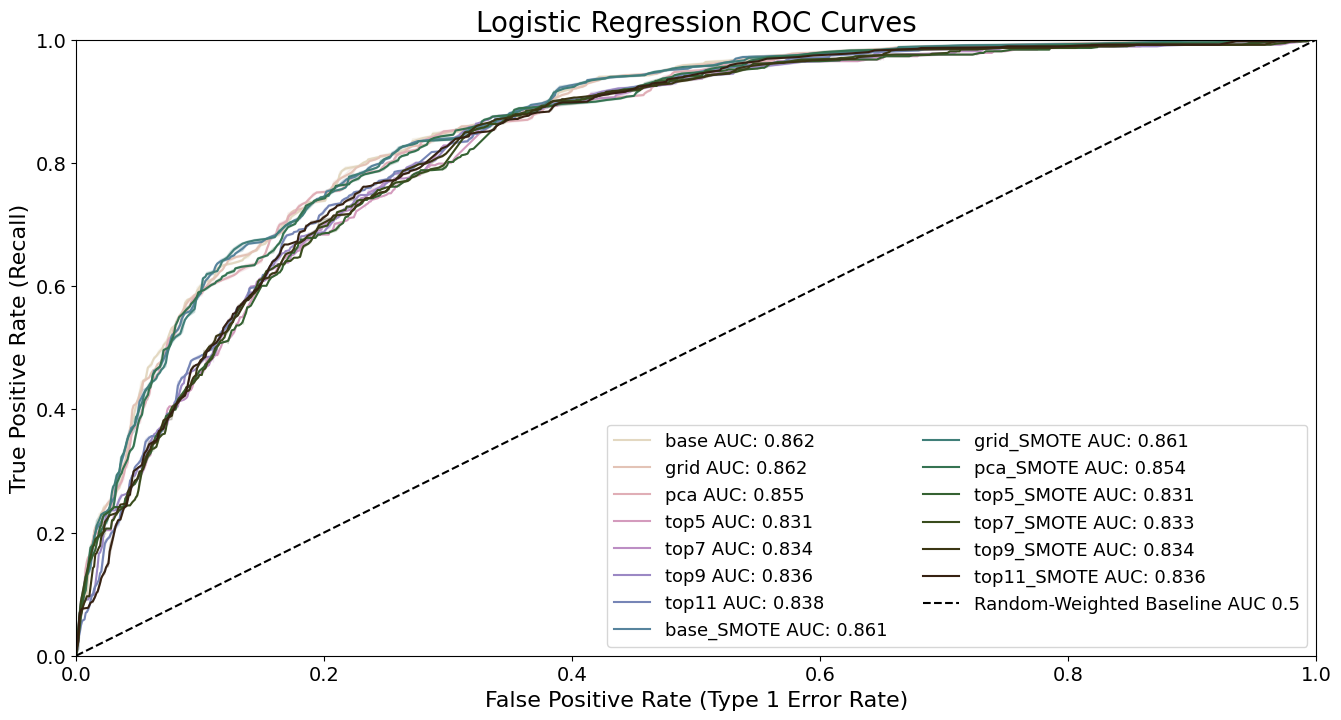

In [28]:
plot_roc_curves('Logistic Regression', logistic_models, X_tests, y_test_encoded);

In [29]:
plot_roc_curves('Logistic Regression Reduced', logistic_models, X_tests, y_test_encoded, reduced = True);

In [30]:
plot_roc_curves('Random Forest', forest_models, X_tests, y_test_encoded);

In [31]:
plot_roc_curves('Random Forest Reduced', forest_models, X_tests, y_test_encoded, reduced = True);

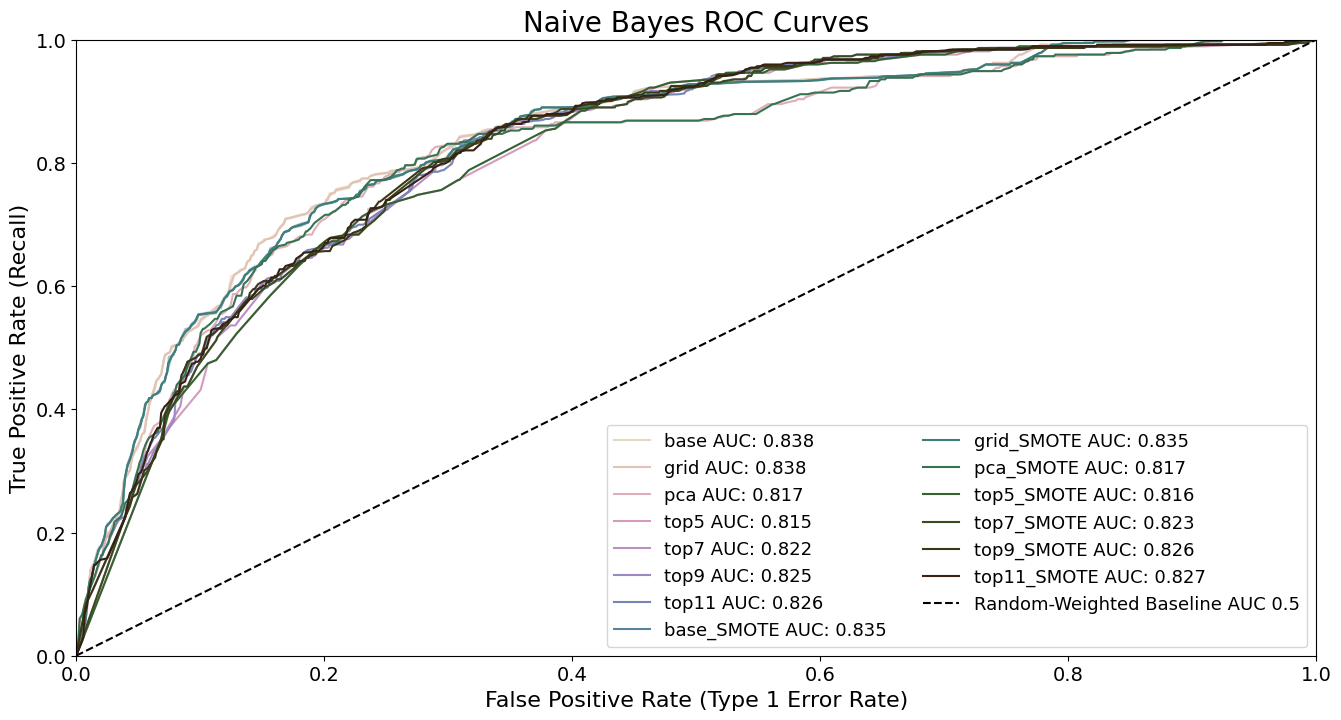

In [32]:
plot_roc_curves('Naive Bayes', bayes_models, X_tests, y_test_encoded);

In [33]:
plot_roc_curves('Naive Bayes Reduced', bayes_models, X_tests, y_test_encoded, reduced = True);

In [34]:
plot_roc_curves('XGBoost', xgb_models, X_tests, y_test_encoded);

In [35]:
plot_roc_curves('XGBoost Reduced', xgb_models, X_tests, y_test_encoded, reduced = True);

### Precision-Recall Curves (PRC)

#### Explanation
Precision-Recall Curves are used to visualize the trade-off between precision and recall for a model at different decision thresholds for classification. PRC can often be more useful and interpretable for datasets with large class imbalances:

- The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets (Saito, T. & Rehmsmeier M. 2015): https://pmc.ncbi.nlm.nih.gov/articles/PMC4349800/

A higher average-precision (AP) indicates a stronger classifier, as the classifier is able to obtain higher levels of recall with less loss in precision. Like ROC AUC, the optimal AP is 1. A strong classifier pulls to the top right of the graph, in comparison to the ROC which pulls to the top left of the graph. Unlike the ROC, a baseline unskilled classifier always predicts the positive class, and thus has an AP equal to the positive class rate in the data set (in this case, 0.26).

The PRC allows us to visualize how we can use the predicted probabilities of models to increase the recall of a model without changing its parameters and how much precision we will lose by doing so.

Notable Interpretations:
- Logistic Regression is a linear model and thus can only create linear decision boundaries. However, it appears the data works well with these restrictions, as Logistic Regression shows a moderate capability in separating the classes and has an average trade-off between precision and recall.
- Random Forest excels at modeling complex data but have a tendency to overfit. However, this ability to create complex decision boundaries leads to higher overall precision at various thresholds with a lower overall trade-off between precision and recall.
- Naive Bayes is a fairly simplistic model which has a tendency to over-predict the positive class. This leads to high recall scores, but noticeably lower precision scores and a much worse trade-off between precision and recall.
- XGBoost requires significant hyperparameter tuning to see the best results. It has a slight tendency to under-predict the positive class, leading to higher precision values but lower recall.

In [36]:
plot_prc('Logistic Regression', logistic_models, X_tests, y_test_encoded);

In [37]:
plot_prc('Logistic Regression Reduced', logistic_models, X_tests, y_test_encoded, reduced = True);

In [38]:
plot_prc('Random Forest', forest_models, X_tests, y_test_encoded);

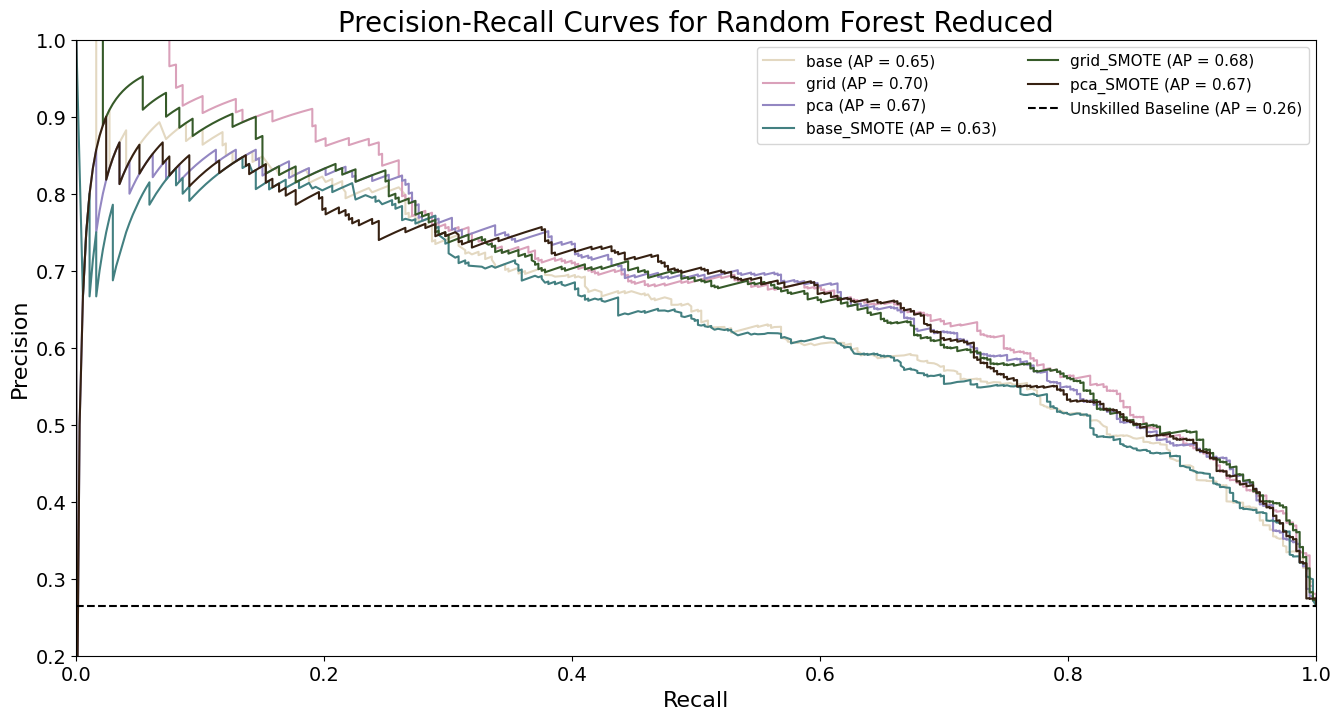

In [39]:
plot_prc('Random Forest Reduced', forest_models, X_tests, y_test_encoded, reduced = True);

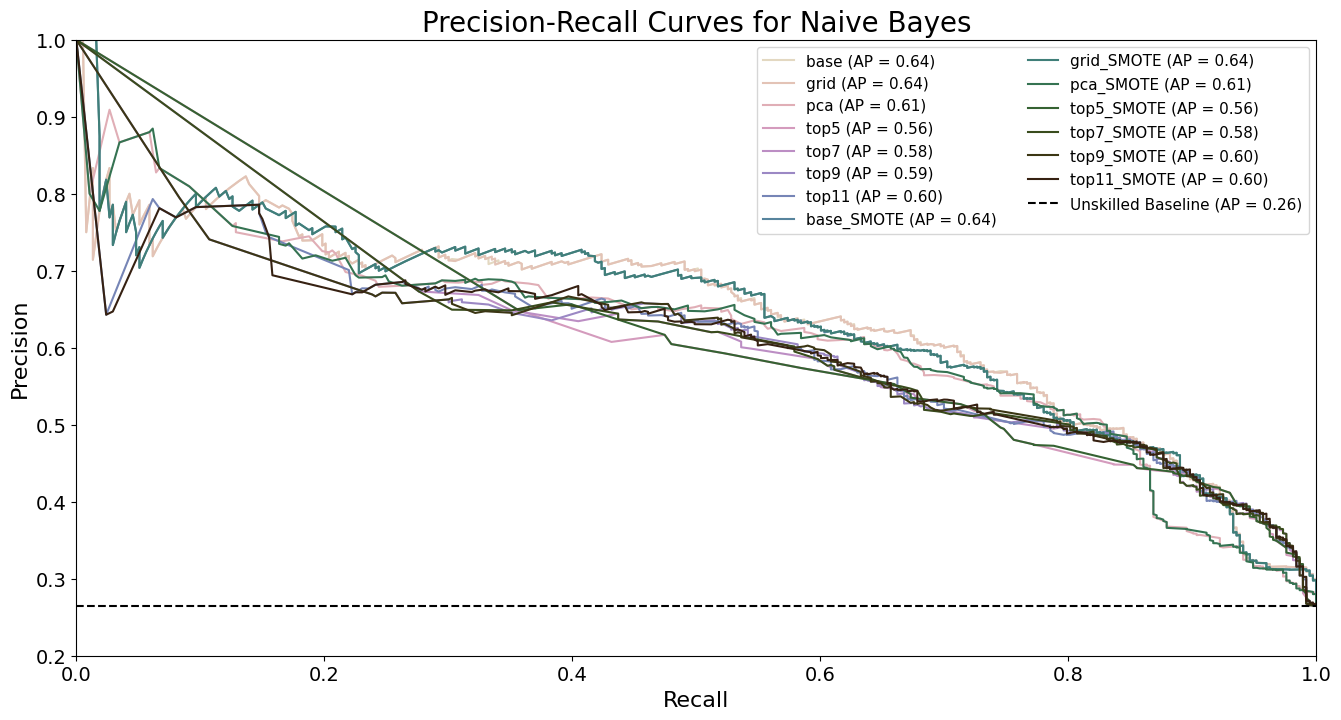

In [40]:
plot_prc('Naive Bayes', bayes_models, X_tests, y_test_encoded);

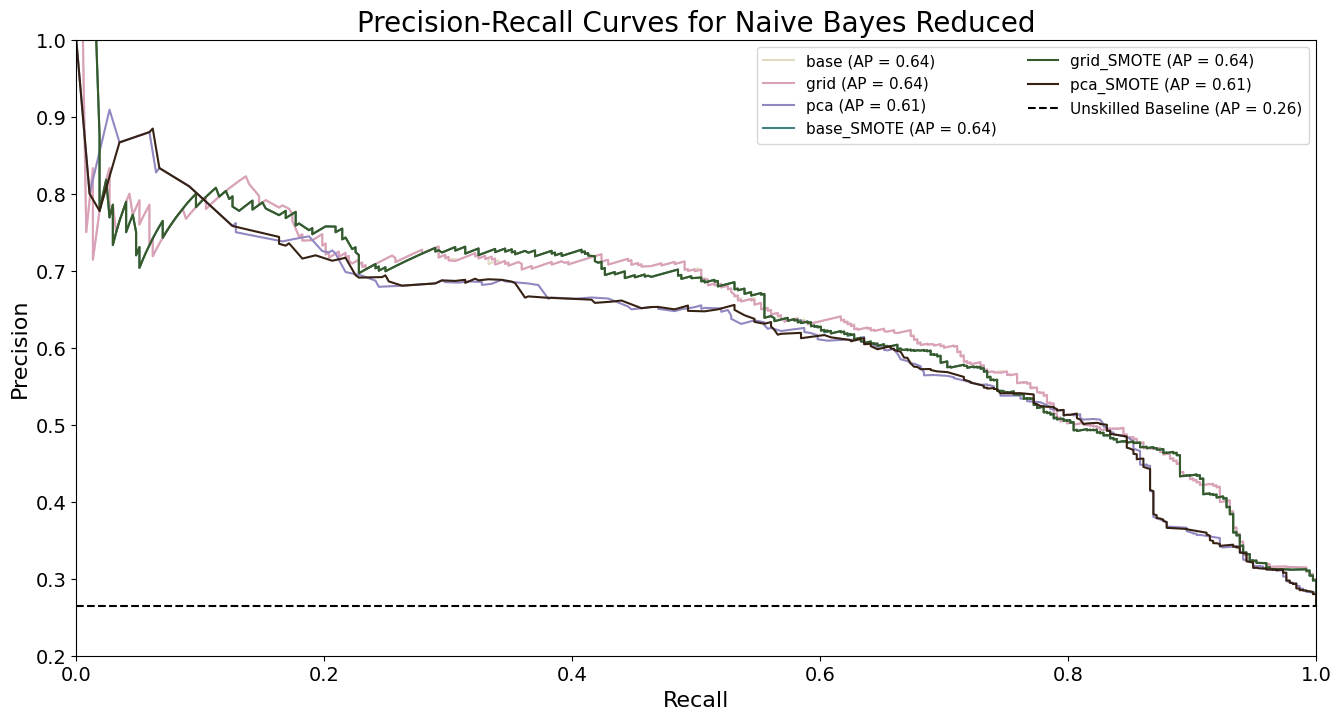

In [41]:
plot_prc('Naive Bayes Reduced', bayes_models, X_tests, y_test_encoded, reduced = True);

In [42]:
plot_prc('XGBoost', xgb_models, X_tests, y_test_encoded);

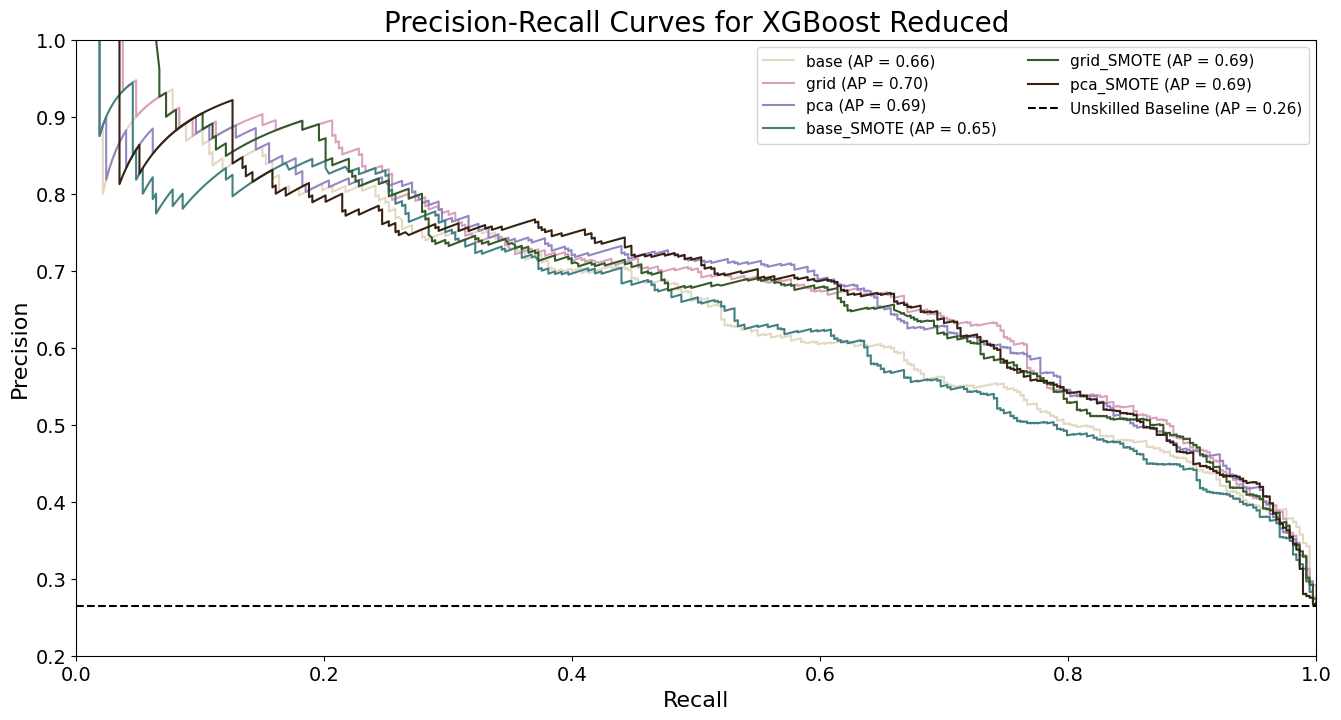

In [43]:
plot_prc('XGBoost Reduced', xgb_models, X_tests, y_test_encoded, reduced = True);

## Best Classifiers

#### Candidate Classifiers:

- logistic_base_SMOTE (Recall: 0.834, Precision: 0.524, F1: 0.643, ROC AUC:, 0.861 PRC AP: 0.68)
- logistic_top5_SMOTE (Recall: 0.877, Precision: 0.474, F1: 0.615, ROC AUC: 0.831, PRC AP: 0.62)


- forest_top7_SMOTE (Recall: 0.850, Precision: 0.488, F1: 0.620, ROC AUC: 0.832, PRC AP: 0.63)
- forest_grid_SMOTE (Recall: 0.810, Precision: 0.554, F1: 0.658, ROC AUC: 0.862, PRC AP: 0.68)


- bayes_base (Recall: 0.812, Precision: 0.502, F1: 0.620, ROC AUC: 0.838, PRC AP: 0.64)
- bayes_base_SMOTE (Recall: 0.879, Precision: 0.464, F1: 0.607, ROC AUC: 0.835, PRC AP: 0.64)
- bayes_pca_SMOTE (Recall: 0.831, Precision: 0.500, F1: 0.624, ROC AUC: 0.817, PRC AP: 0.61)


- xgboost_top7_SMOTE (Recall: 0.839, Precision: 0.482, F1: 0.613, ROC AUC: 0.835, PRC AP: 0.63)
- xgboost_grid_SMOTE (Recall: 0.748, Precision: 0.581, F1: 0.654, ROC AUC: 0.860, PRC AP: 0.69)

Other classifiers were rejected for low Recall scores or lower overall metric scores.

The project specifications said to place an emphasis on Recall; however, it should be noted that Recall is calculated based on a decision threshold of 0.5 and can be modulated based on different decision thresholds. High Recall scores may be obtained by heavily biased classifiers which over-predict the positive class (in our case, customer did churn). Thus, taking into account ROC AUC and PRC AP, as well as F1-Score to try to find a balanced but high Recall classifier, the best candidates for each model are:

- logistic_base_SMOTE (Recall: 0.834, Precision: 0.524, F1: 0.643, ROC AUC:, 0.861 PRC AP: 0.68)
- forest_grid_SMOTE (Recall: 0.810, Precision: 0.554, F1: 0.658, ROC AUC: 0.862, PRC AP: 0.68)
- bayes_base_SMOTE (Recall: 0.879, Precision: 0.464, F1: 0.607, ROC AUC: 0.835, PRC AP: 0.64)
- xgboost_grid_SMOTE (Recall: 0.748, Precision: 0.581, F1: 0.654, ROC AUC: 0.860, PRC AP: 0.69)

Using fewer features tends to result in a higher Recall at the expense of Precision. This is because we are introducing higher bias by assuming a simpler underlying feature set, but with fewer features, the models struggle to capture the complexity in the data and are overconfident in their predictions. If Recall is valued much more highly than Precision, those other models may be preferable, espcially since dimensionality reduction could be useful for much larger datasets.

In [44]:
best_models = []
best_models.append([x for x in logistic_models if x[0] == 'logreg_base_SMOTE'][0])
best_models.append([x for x in forest_models if x[0] == 'forest_grid_SMOTE'][0])
best_models.append([x for x in bayes_models if x[0] == 'bayes_base_SMOTE'][0])
best_models.append([x for x in xgb_models if x[0] == 'xgboost_grid_SMOTE'][0])

### Training vs. Testing Performance on Base vs. Best Models

#### Logistic Base vs. Logistic Best

The logistic model is not prone to overfitting, but struggles to capture the positive class without the SMOTE oversampling.

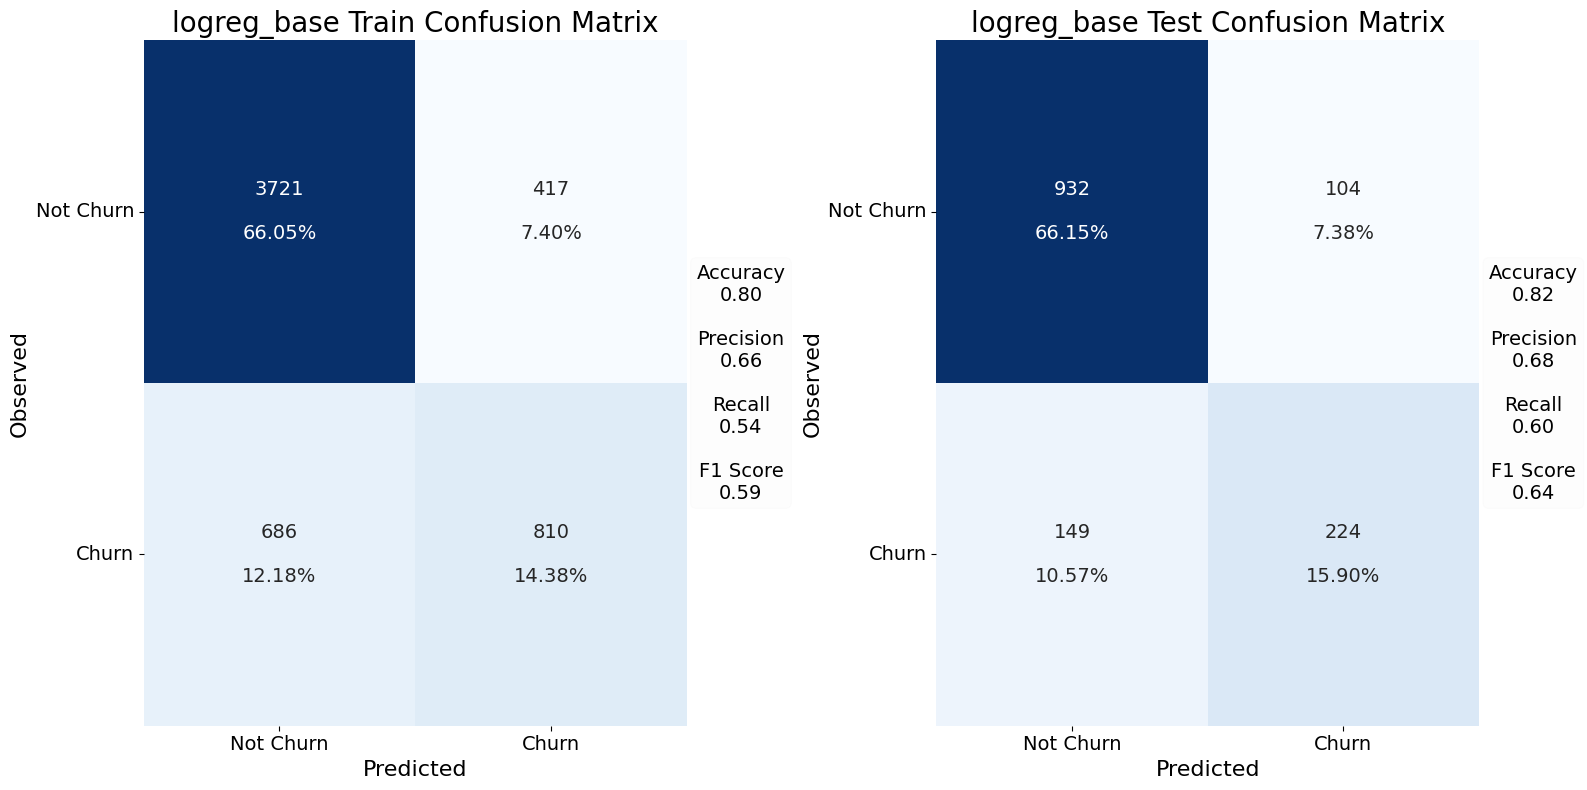

In [45]:
train_test_performance(logistic_models[0], X_trains, X_tests, y_train_encoded, y_test_encoded);

In [46]:
train_test_performance(best_models[0], X_trains, X_tests, y_train_encoded, y_test_encoded);

#### Forest Base vs. Forest Best

Random Forest base heavily overfits. With SMOTE and grid searching, the Random Forest has stronger Precision than the Logistic model and no longer overfits.

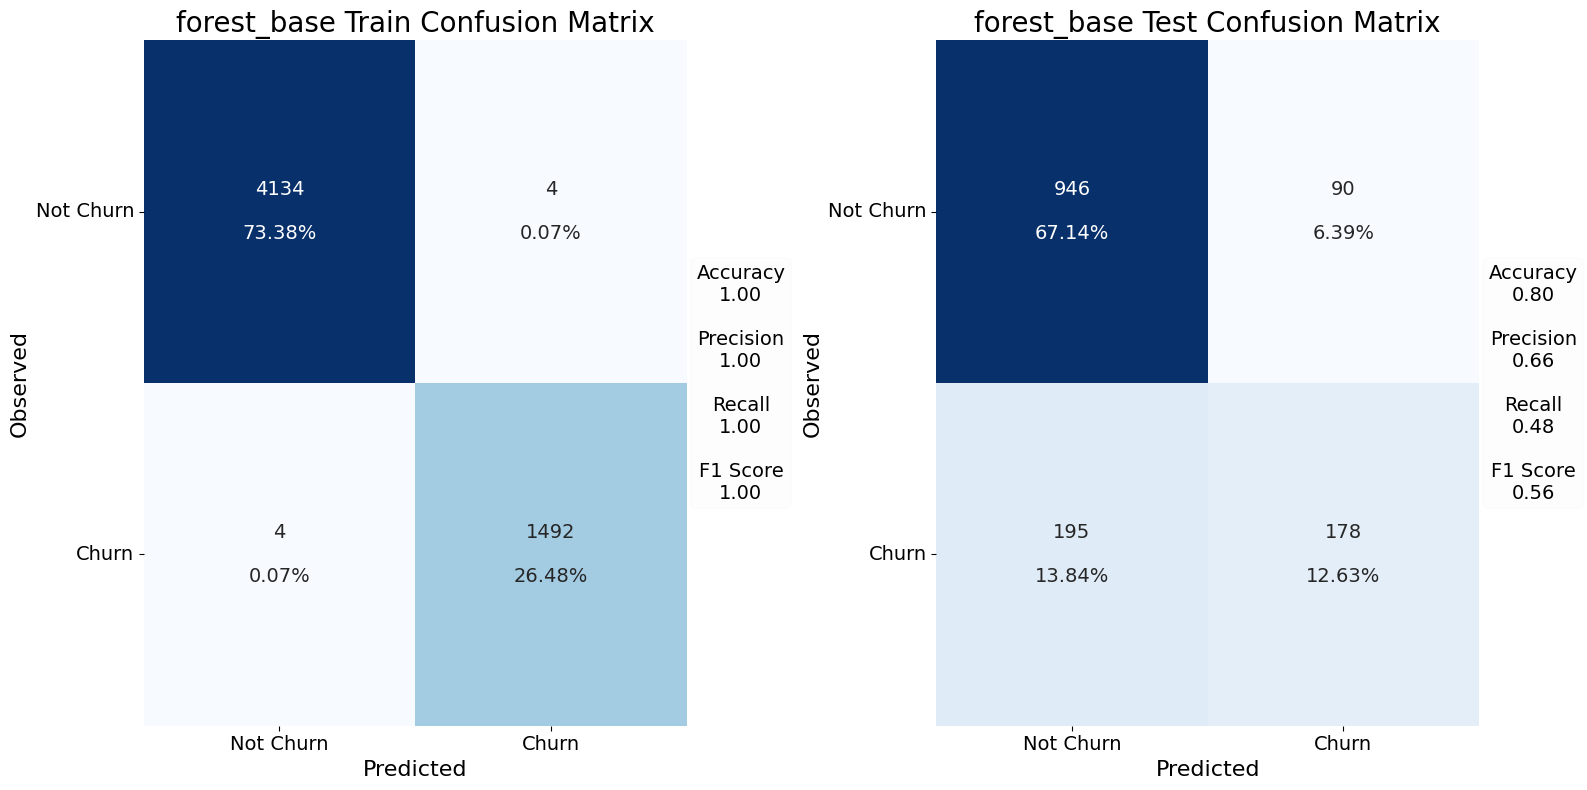

In [47]:
train_test_performance(forest_models[0], X_trains, X_tests, y_train_encoded, y_test_encoded);

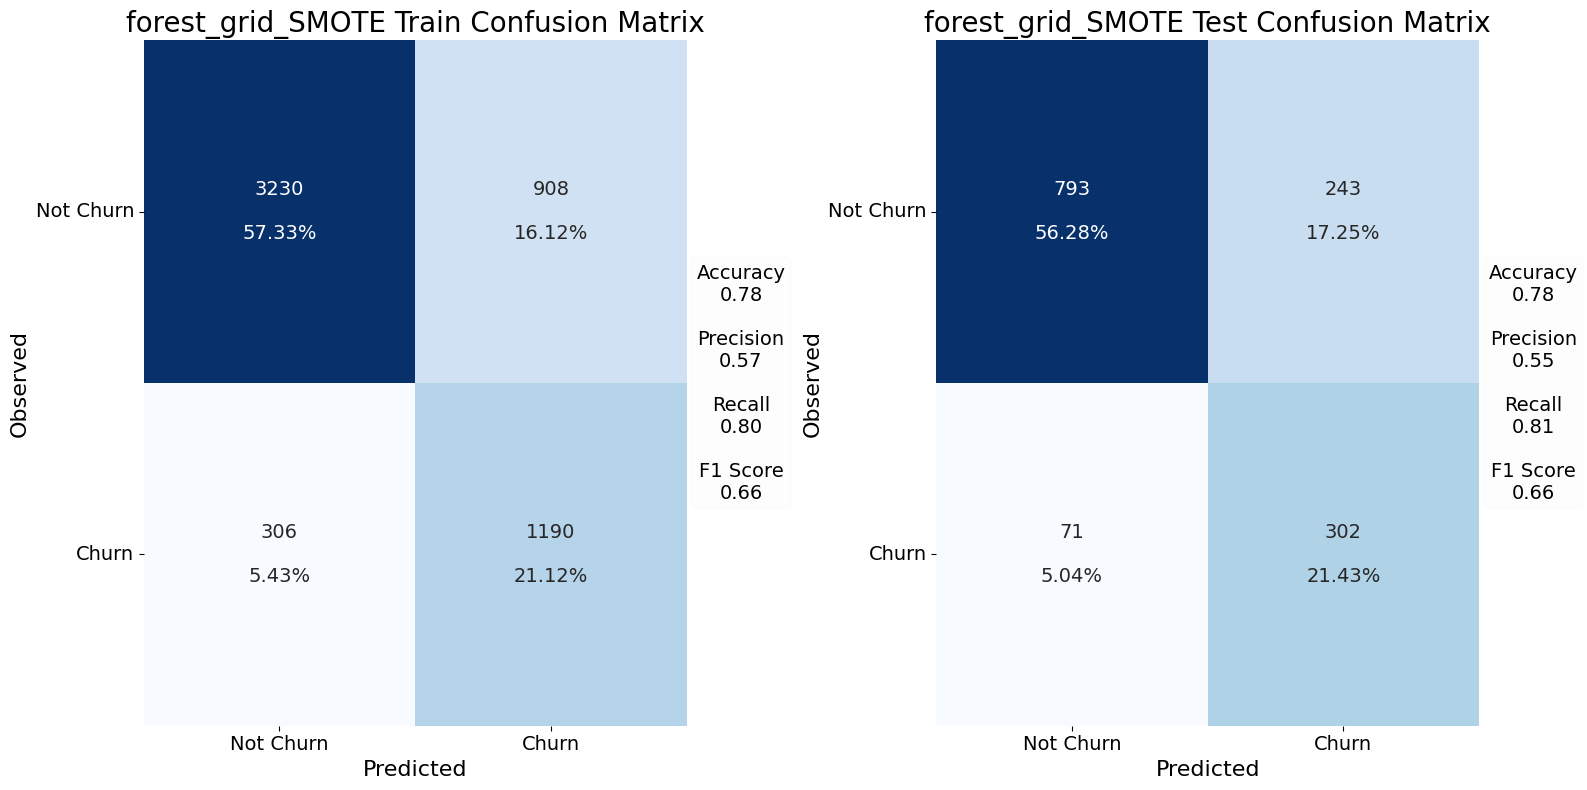

In [48]:
train_test_performance(best_models[1], X_trains, X_tests, y_train_encoded, y_test_encoded);

#### Bayes Base vs. Bayes Best

Naive Bayes models are not prone to overfitting and perform fairly well even without SMOTE oversampling.

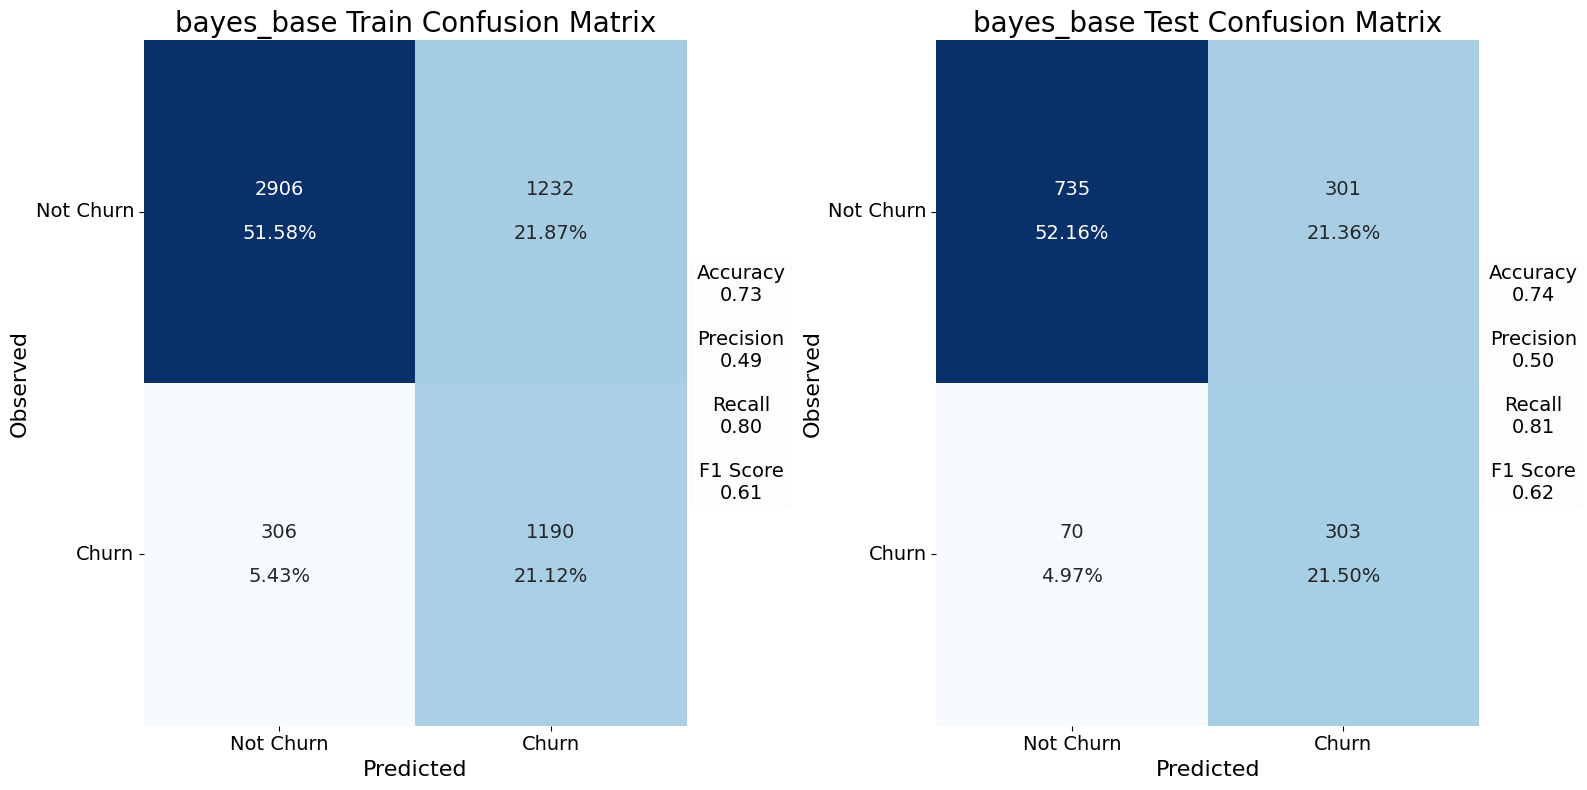

In [49]:
train_test_performance(bayes_models[0], X_trains, X_tests, y_train_encoded, y_test_encoded);

In [50]:
train_test_performance(best_models[2], X_trains, X_tests, y_train_encoded, y_test_encoded);

#### XGBoost Base vs. XGBoost Best

XGBoost is prone to heavy overfitting without tuning. XGBoost has many more parameters than any of the other models tested and would benefit from even greater tuning than was performed for this project. Grid searching and SMOTE oversampling removes the overfitting issue and causes the model to better capture the positive class.

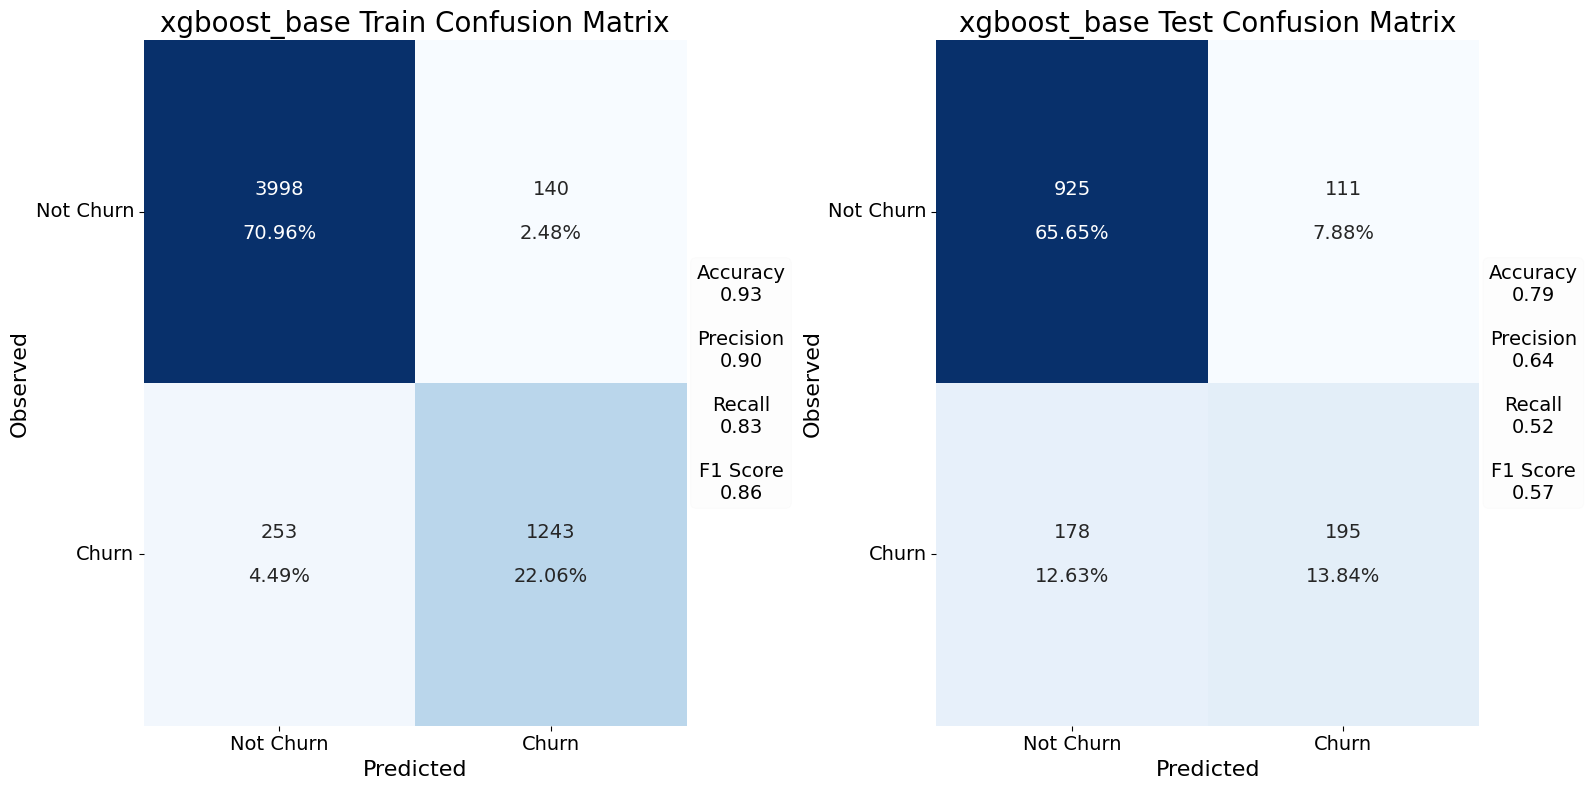

In [51]:
train_test_performance(xgb_models[0], X_trains, X_tests, y_train_encoded, y_test_encoded);

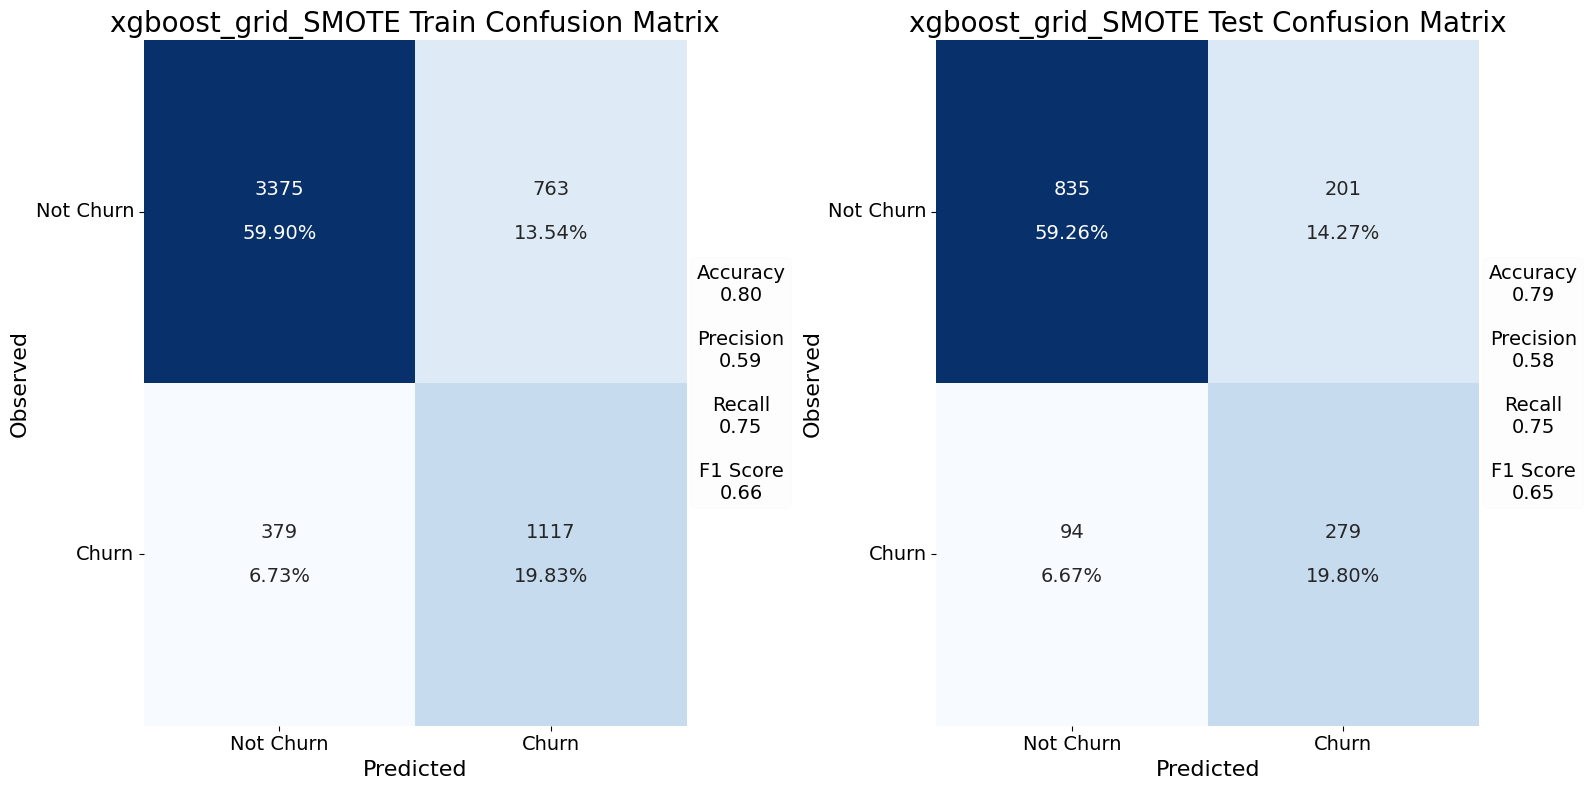

In [52]:
train_test_performance(best_models[3], X_trains, X_tests, y_train_encoded, y_test_encoded);

### Best Models Classification Metrics

Based on recall, the best model is Naive Bayes; however, the low precision score seems undesirable. Logistic Regression gives the second highest recall with a significant improvement in precision. Random Forest appears to be the most balanced based on F1 Score, although XGBoost is the most precise. 

In [53]:
metrics_across_models('Best Models', best_models, X_tests, y_test_encoded, same_name = False)

### Best Models ROC Curves

Random Forest, XGBoost, and Logistic Regression all appear to be excellent candidates at lower decision thresholds (thus leading to higher recall and higher type 1 error rate), although Random Forest is notable for being able to reach ~0.8 recall with only a ~0.23-0.25 type 1 error rate.

In [54]:
plot_roc_curves('Best Models', best_models, X_tests, y_test_encoded, same_name = False);

### Best Models PRC

Much like the ROC Curves, Random Forest, Logistic Regression, and XGBoost all perform similarly. Random Forest still appears to be able to obtain the best recall scores with moderate precision at ~0.82 recall to ~0.55 precision.

In [55]:
plot_prc('Best Models', best_models, X_tests, y_test_encoded, same_name = False);

## Conclusion and Future Steps

In datasets with heavy class imbalances, models will struggle to predict the minority class without resampling methods. The churn dataset used for this project had a class imbalance of 73.5% to 26.5% for negative and positive classes. Most of the models experienced an increase of 8 to 25+ points in recall when used on the SMOTE resampled set versus the base version.

Removing collinear features based on VIF and subsampling the feature space based on f-scores had the predictable result of reducing the effectiveness of all models. However, most models performed fairly well even when using only the top 5 of the 19 total features in the dataset, which indicates that it may be possible to have comparable performance with lower data complexity. Many of the models performed quite well using the first 9 components of the PCA transformed dataset, despite those components only explaining ~82% of the variance in the dataset, showing that PCA transformed data may be another viable alternative for dimensionality reduction of the feature space.

The Random Forest model seems to have resulted in the most robust model, with high recall and moderate precision scores, as well as the strongest ROC and PRC curves. Naive Bayes had the strongest recall but was also the simplest model with low precision scores. Logistic Regression also performed well while being much simpler and faster to train than the Random Forest model. The XGBoost model is more complex than Logistic Regression but is faster to train than the Random Forest model, although it did not perform quite as well.

#### Future Improvements:
- XGBoost is a model with a lot of hyperparameters which can dramatically affect its performance. A multi-step hyperparameter tuning strategy would likely result in much better results than the one-step pass that was done.
- There are many other models that could be tested on this data, including ensemble methods such as stacked or voting classifiers. These were not performed for the sake of time.
- Post-training feature importance analysis using Shapley Additive Explanations (SHAP) would be beneficial in identifying low- and high-impact features for futher model tuning and data understanding.